<a href="https://colab.research.google.com/github/adnaneaabbar/face-recognition-for-authorized-staff/blob/master/Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing modules

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import sys
sys.path.append("/face-recognition/")
from fr_utils import *
from inception_blocks_v2 import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=sys.maxsize)

# Using a ConvNet  to compute encodings

In [0]:
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

In [6]:
print("Total Params:", FRmodel.count_params())

Total Params: 3743280


# The Triplet Loss

These triplets are picked from our training dataset. We will write $(A^{(i)}, P^{(i)}, N^{(i)})$ to denote the $i$-th training example. 

We'd like to make sure that an image $A^{(i)}$ of an individual is closer to the Positive $P^{(i)}$ than to the Negative image $N^{(i)}$) by at least a margin $\alpha$:

$$\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 + \alpha < \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$$

We would thus like to minimize the following "triplet cost":

$$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \underbrace{\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2}_\text{(1)} - \underbrace{\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2}_\text{(2)} + \alpha \large ] \small_+ \tag{3}$$

Here, we are using the notation "$[z]_+$" to denote $max(z,0)$.  

Notes:
- The term (1) is the squared distance between the anchor "A" and the positive "P" for a given triplet; we want this to be small. 
- The term (2) is the squared distance between the anchor "A" and the negative "N" for a given triplet, we want this to be relatively large. It has a minus sign preceding it because minimizing the negative of the term is the same as maximizing that term.
- $\alpha$ is called the margin. It is a hyperparameter that we pick manually. We will use $\alpha = 0.2$.

In [0]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when we define a loss in Keras, we don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    # Step 1: Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis = -1)
    # Step 2: Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis = -1)
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = pos_dist - neg_dist + alpha
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))
    
    return loss

# Loading the pre-trained model

### This is loading a total of 226 files of weights, an equivalent of a 67Mo size, it should take a couple of minutes.

In [0]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

#  Applying the model

##  Face Verification

First we build a database containing one encoding vector for each person who is allowed to enter the office. To generate the encoding we use `img_to_encoding(image_path, model)`, which runs the forward propagation of the model on the specified image.

In [0]:
database = {}
database["danielle"] = img_to_encoding("/face-recognition/images/danielle.png", FRmodel)
database["younes"] = img_to_encoding("/face-recognition/images/younes.jpg", FRmodel)
database["tian"] = img_to_encoding("/face-recognition/images/tian.jpg", FRmodel)
database["kian"] = img_to_encoding("/face-recognition/images/kian.jpg", FRmodel)
database["dan"] = img_to_encoding("/face-recognition/images/dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding("/face-recognition/images/sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding("/face-recognition/images/bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding("/face-recognition/images/kevin.jpg", FRmodel)
database["felix"] = img_to_encoding("/face-recognition/images/felix.jpg", FRmodel)
database["benoit"] = img_to_encoding("/face-recognition/images/benoit.jpg", FRmodel)
database["arnaud"] = img_to_encoding("/face-recognition/images/arnaud.jpg", FRmodel)

Now, when someone shows up at the building door and swipes their ID card (thus giving us their name), we can look up their encoding in the database, and use it to check if the person standing at the front door matches the name on the ID.

In [0]:
def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
    image_path -- path to an image
    identity -- string, name of the person we'd like to verify the identity. Has to be an employee who works in the office.
    database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
    model -- our Inception model instance in Keras
    
    Returns:
    dist -- distance between the image_path and the image of "identity" in the database.
    door_open -- True, if the door should open. False otherwise.
    """
        
    # Step 1: Compute the encoding for the image. Use img_to_encoding() see example above.
    encoding = img_to_encoding(image_path, model)
    
    # Step 2: Compute distance with identity's image
    dist = np.linalg.norm(encoding - database[identity])
    
    # Step 3: Open the door if dist < 0.7, else don't open
    if dist < 0.7:
        print("It's " + str(identity) + ". Welcome in !!!!")
        door_open = True
    else:
        print("It's not " + str(identity) + ". Please go away !!!!")
        door_open = False
                
    return dist, door_open

The camera takes a picture of people trying to access the office, labeled in the images folder as **camera_i.jpg**.

Mr.Younes approaches the camera with his ID

In [11]:
verify("/face-recognition/images/camera_0.jpg", "younes", database, FRmodel)

It's younes. Welcome in !!!!


(0.6710072, True)

Another person approaches the camera with Mr.Younes's ID claiming to be him, let's verify her identity.

In [12]:
verify("/face-recognition/images/camera_2.jpg", "younes", database, FRmodel)

It's not younes. Please go away !!!!


(0.9982575, False)

## Face Recognition

Our face verification system is mostly working well. But since Mr.Younes got his ID card stolen, when he came back to the office the next day, he couldn't get in! 

To solve this, we'd like to change our face verification system to a face recognition system.

This way, no one has to carry an ID card anymore. An authorized person can just walk up to the building, and the door will unlock for them! 


In [0]:
def who_is_it(image_path, database, model):
    """
    Implements face recognition for the office by finding who is the person on the image_path image.
    
    Arguments:
    image_path -- path to an image
    database -- database containing image encodings along with the name of the person on the image
    model -- your Inception model instance in Keras
    
    Returns:
    min_dist -- the minimum distance between image_path encoding and the encodings from the database
    identity -- string, the name prediction for the person on image_path
    """
        
    ## Step 1: Compute the target "encoding" for the image. Use img_to_encoding() see example above.
    encoding = img_to_encoding(image_path, model)
    
    ## Step 2: Find the closest encoding ##
    
    # Initialize "min_dist" to a large value, say 100
    min_dist = 100
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current db_enc from the database.
        dist = np.linalg.norm(encoding - db_enc)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name.
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.7:
        print("You are not authorized.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

Let's test this !

In [0]:
from matplotlib.pyplot import imshow, imread

Mr.Younes is at the front-door and the camera takes a picture of him ("images/camera_0.jpg"). Let's see if your who_it_is() algorithm identifies Mr.Younes. 

In [15]:
who_is_it("/face-recognition/images/camera_0.jpg", database, FRmodel)

it's younes, the distance is 0.6710072


(0.6710072, 'younes')

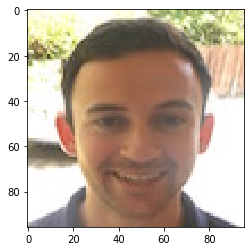

In [16]:
younes = imread('/face-recognition/images/camera_0.jpg')
imshow(younes)

Let us check.

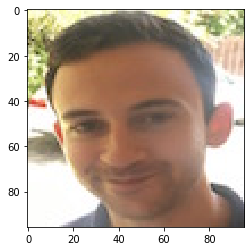

In [17]:
younes = imread('/face-recognition/images/younes.jpg')
imshow(younes)

Someone else is at the door let's see who is it.

In [18]:
who_is_it("/face-recognition/images/camera_3.jpg", database, FRmodel)

it's bertrand, the distance is 0.36125994


(0.36125994, 'bertrand')

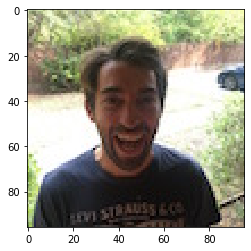

In [19]:
bertrand = imread('/face-recognition/images/camera_3.jpg')
imshow(bertrand)

Let us check.

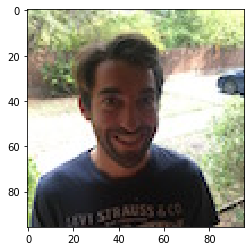

In [20]:
bertrand = imread('/face-recognition/images/bertrand.jpg')
imshow(bertrand)

### References:

- Florian Schroff, Dmitry Kalenichenko, James Philbin (2015). [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/pdf/1503.03832.pdf)
- Yaniv Taigman, Ming Yang, Marc'Aurelio Ranzato, Lior Wolf (2014). [DeepFace: Closing the gap to human-level performance in face verification](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf) 
- The pretrained model we use is inspired by Victor Sy Wang's implementation and was loaded using his code: https://github.com/iwantooxxoox/Keras-OpenFace.
- Our implementation also took a lot of inspiration from the official FaceNet github repository: https://github.com/davidsandberg/facenet 
